## Importing Necessary Libraries

In [1]:
from keras.layers import Dense, Dropout,Input,ReLU
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


## Loading Data

In [2]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

In [3]:
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (60000, 28, 28)
X_test shape:  (10000, 28, 28)
y_train shape:  (60000,)
y_test shape:  (10000,)


## Normalization

In [4]:
X_train=(X_train.astype(np.float32)-127.5)/127.5

In [5]:
print("X_train shape: ",X_train.shape)

X_train shape:  (60000, 28, 28)


In [6]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print(X_train.shape)

(60000, 784)


## Visualize Some Train Example

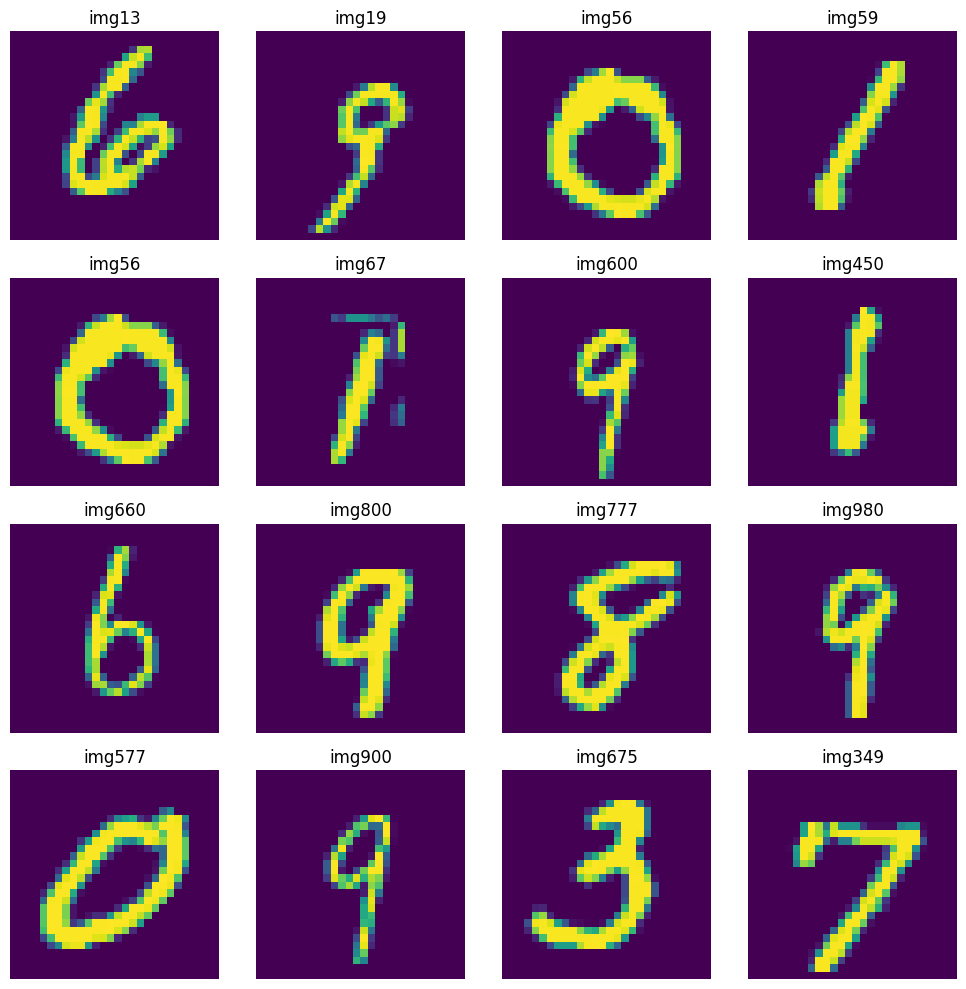

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

indices = [13, 19, 56, 59, 56, 67, 600, 450, 660, 800, 777, 980,577,900,675,349]

for i, idx in enumerate(indices):
    img = X_train[idx].reshape((28, 28))

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"img{idx}")

plt.tight_layout()
plt.show()

## Creating Generator

In [8]:
def create_generator():
  generator=Sequential()
  generator.add(Dense(units=512,input_dim=100))
  generator.add(ReLU())

  generator.add(Dense(units=512))
  generator.add(ReLU())

  generator.add(Dense(units=1024))
  generator.add(ReLU())

  generator.add(Dense(units=784,activation="tanh"))


  generator.compile(loss="binary_crossentropy",
                    optimizer=Adam(lr=0.0001,beta_1=0.5))
  return generator


In [9]:
gen=create_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

## Create Discriminator

In [10]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))

    discriminator.add(Dense(units=512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))


    discriminator.add(Dense(units=256))
    discriminator.add(ReLU())

    discriminator.add(Dense(units=1,activation="sigmoid"))  #output layer

    #compiling

    discriminator.compile(loss="binary_crossentropy",
                          optimizer=Adam(lr=0.0001,beta_1=0.5))

    return discriminator





In [11]:
d=create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

## Create GANs

In [12]:
def create_gan(discriminator,generator):
  discriminator.trainable=False
  gan_input=Input(shape=(100,))
  x=generator(gan_input)
  gan_output=discriminator(x)
  gan=Model(inputs=gan_input,outputs=gan_output)

  #compiling

  gan.compile(loss="binary_crossentropy",optimizer="adam")

  return gan

In [13]:
gan=create_gan(d,gen)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1643280   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


## Training GANs

In [14]:
from tqdm import tqdm
epochs=50
batch_size=256
for epoch in range(epochs):
    print("Epochs: ",epoch+1)
    for _ in tqdm(range(batch_size)):
        noise=np.random.normal(0,1,[batch_size,100])
        generated_images=gen.predict(noise,verbose=0)
        image_batch=X_train[np.random.randint(low=0,high=X_train.shape[0],size=256)]

        x=np.concatenate([image_batch,generated_images])

        y_dis=np.zeros(batch_size*2)
        y_dis[:batch_size]=0.1

        d.trainable=True
        d.train_on_batch(x,y_dis)

        noise=np.random.normal(0,1,[batch_size,100])
        y_gen=np.ones(batch_size)
        d.trainable=False

        gan.train_on_batch(noise,y_gen)

Epochs:  1


100%|██████████| 256/256 [01:56<00:00,  2.19it/s]


Epochs:  2


100%|██████████| 256/256 [01:46<00:00,  2.41it/s]


Epochs:  3


100%|██████████| 256/256 [01:39<00:00,  2.58it/s]


Epochs:  4


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  5


100%|██████████| 256/256 [01:38<00:00,  2.61it/s]


Epochs:  6


100%|██████████| 256/256 [01:38<00:00,  2.61it/s]


Epochs:  7


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  8


100%|██████████| 256/256 [01:37<00:00,  2.63it/s]


Epochs:  9


100%|██████████| 256/256 [01:37<00:00,  2.64it/s]


Epochs:  10


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  11


100%|██████████| 256/256 [01:35<00:00,  2.67it/s]


Epochs:  12


100%|██████████| 256/256 [01:34<00:00,  2.71it/s]


Epochs:  13


100%|██████████| 256/256 [01:35<00:00,  2.69it/s]


Epochs:  14


100%|██████████| 256/256 [01:36<00:00,  2.66it/s]


Epochs:  15


100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


Epochs:  16


100%|██████████| 256/256 [01:34<00:00,  2.71it/s]


Epochs:  17


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  18


100%|██████████| 256/256 [01:35<00:00,  2.69it/s]


Epochs:  19


100%|██████████| 256/256 [01:39<00:00,  2.57it/s]


Epochs:  20


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  21


100%|██████████| 256/256 [01:33<00:00,  2.73it/s]


Epochs:  22


100%|██████████| 256/256 [01:30<00:00,  2.82it/s]


Epochs:  23


100%|██████████| 256/256 [01:35<00:00,  2.69it/s]


Epochs:  24


100%|██████████| 256/256 [01:34<00:00,  2.71it/s]


Epochs:  25


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  26


100%|██████████| 256/256 [01:34<00:00,  2.70it/s]


Epochs:  27


100%|██████████| 256/256 [01:36<00:00,  2.66it/s]


Epochs:  28


100%|██████████| 256/256 [01:38<00:00,  2.59it/s]


Epochs:  29


100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


Epochs:  30


100%|██████████| 256/256 [01:33<00:00,  2.73it/s]


Epochs:  31


100%|██████████| 256/256 [01:35<00:00,  2.69it/s]


Epochs:  32


100%|██████████| 256/256 [01:34<00:00,  2.71it/s]


Epochs:  33


100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


Epochs:  34


100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


Epochs:  35


100%|██████████| 256/256 [01:37<00:00,  2.63it/s]


Epochs:  36


100%|██████████| 256/256 [01:35<00:00,  2.67it/s]


Epochs:  37


100%|██████████| 256/256 [01:38<00:00,  2.61it/s]


Epochs:  38


100%|██████████| 256/256 [01:36<00:00,  2.67it/s]


Epochs:  39


100%|██████████| 256/256 [01:35<00:00,  2.67it/s]


Epochs:  40


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  41


100%|██████████| 256/256 [01:38<00:00,  2.60it/s]


Epochs:  42


100%|██████████| 256/256 [01:35<00:00,  2.67it/s]


Epochs:  43


100%|██████████| 256/256 [01:38<00:00,  2.60it/s]


Epochs:  44


100%|██████████| 256/256 [01:36<00:00,  2.65it/s]


Epochs:  45


100%|██████████| 256/256 [01:38<00:00,  2.59it/s]


Epochs:  46


100%|██████████| 256/256 [01:39<00:00,  2.58it/s]


Epochs:  47


100%|██████████| 256/256 [01:37<00:00,  2.64it/s]


Epochs:  48


100%|██████████| 256/256 [01:37<00:00,  2.63it/s]


Epochs:  49


100%|██████████| 256/256 [01:38<00:00,  2.61it/s]


Epochs:  50


100%|██████████| 256/256 [01:38<00:00,  2.59it/s]


In [15]:
#save the model
gen.save_weights('gans_model.h5')

## Visualize the Pictures of Produced Using the GANs Model

4/4 [==============================] - 0s 8ms/step


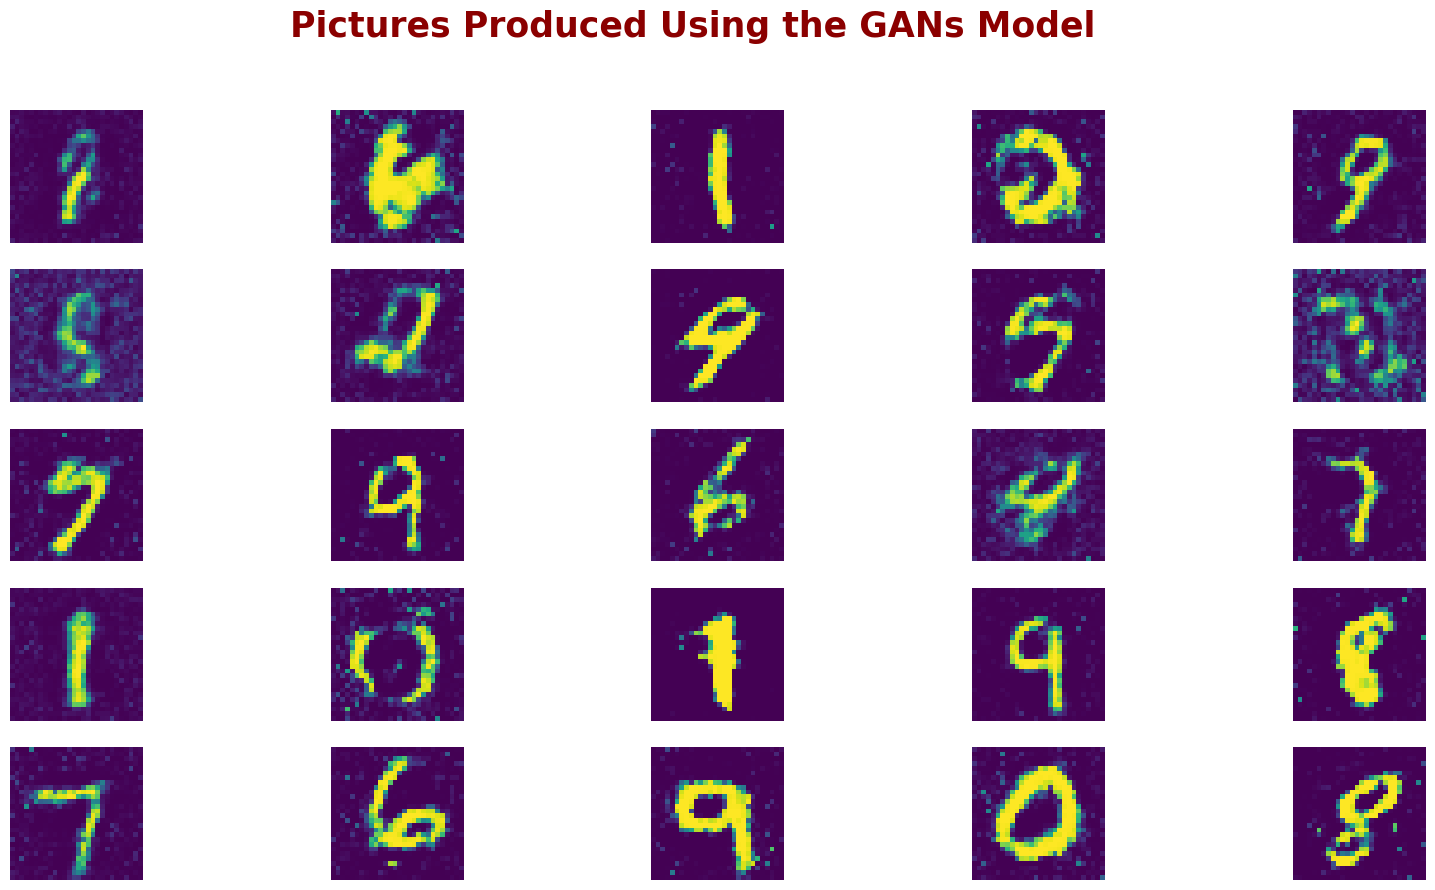

In [16]:
plt.figure(figsize=(20,10))
noise= np.random.normal(loc=0, scale=1, size=[100, 100])
generated_images = gen.predict(noise)
generated_images = generated_images.reshape(100,28,28)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_images[i], interpolation='nearest')
    plt.axis('off')

plt.suptitle("Pictures Produced Using the GANs Model", fontsize = 25 , color = "darkred", fontweight = 'bold')
plt.show()